In [ ]:
!mkdir hamiltorch

mkdir: cannot create directory ‘hamiltorch’: File exists


In [ ]:
import numpy as np
import pandas as pd
import torch
import hamiltorch
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

In [ ]:
hamiltorch.set_random_seed(123)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
class ConvNeuralNet(nn.Module):
    # Determine what layers and their order in CNN object 
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()
        self.conv_layer = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=4, stride=2,padding=0)
        self.avg_pool = nn.AvgPool2d(kernel_size = 2, stride = 2, padding=0)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(72,num_classes,bias=True)
    
    # Propagate data across layers    
    def forward(self, x):
        out = self.conv_layer(x)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.relu(out)
        out = self.fc(out)
        
        return out

net = ConvNeuralNet(10)

weights_size = [p.size() for p in net.parameters()]

lambda_W= 16 # inverse precision of prior on convolutional filter
lambda_W_2= 72 # inverse precision of prior on second layer weights
lambda_b= 16 # inverse precision of prior on convolution bias
lambda_b_2= 72 # inverse precision of prior on second layer bias

tau_vals = [lambda_W, lambda_b, lambda_W_2, lambda_b_2]
tau_list = torch.cat([torch.ones(weights_size[i]).flatten()*tau_vals[i] for i in range(len(weights_size))]).to(device)


In [ ]:
n=60000
n_test=5000

file_mnist=np.load("mnist.npz",allow_pickle=True)
X_train=torch.tensor(file_mnist["x_train"]) #use only half of the training set
X_test=torch.tensor(file_mnist['x_test']) #use only half of the test set
X_train=X_train.reshape([60000,1,28,28])[:n]/255
X_test=X_test.reshape([10000,1,28,28])[:n_test]/255
mean_X=torch.mean(X_train)
std_X=torch.std(X_train)

X_train=(X_train-mean_X)/std_X
X_test=(X_test-mean_X)/std_X
y_train=torch.tensor(file_mnist['y_train']).type(torch.long).flatten()[:n]
y_test=torch.tensor(file_mnist['y_test']).type(torch.long).flatten()[:n_test]

X_test = torch.Tensor(X_test).to(device)
y_test = torch.Tensor(y_test).to(device)
X_train = torch.Tensor(X_train).to(device)
y_train = torch.Tensor(y_train).to(device)

In [ ]:
delta = 10
step_size = 1e-3
num_samples = 1000
L = 50
tau_out = 1/float(delta)/2

Parameter size:  764


100%|██████████| 1000/1000 [48:55<00:00,  2.94s/it]


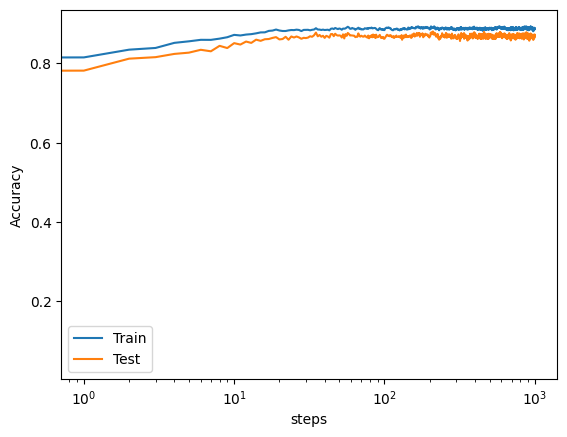

In [ ]:
network = net.to(device)

hamiltorch.set_random_seed(123)
params_init = hamiltorch.util.flatten(network).to(device).clone()
print('Parameter size: ',params_init.shape[0])
N_tr=X_train.shape[0]

params_hmc = hamiltorch.sample_model(network, X_train, y_train, model_loss='multi_class_linear_output',params_init=params_init, num_samples=num_samples,
                               step_size=step_size, num_steps_per_sample=L,tau_out=tau_out,normalizing_const=N_tr, tau_list=tau_list)

pred_list, log_prob_list = hamiltorch.predict_model(network, x=X_train, y=y_train, model_loss='multi_class_linear_output', samples=params_hmc[:], tau_out=tau_out, tau_list=tau_list)
accuracy_zero = (pred_list.data.detach().argmax(axis=2) == y_train.detach()).to("cpu").numpy().mean(axis=1)

pred_list, log_prob_list = hamiltorch.predict_model(network, x=X_test, y=y_test, model_loss='multi_class_linear_output', samples=params_hmc[:], tau_out=tau_out, tau_list=tau_list)
accuracy_zero_test = (pred_list.data.detach().argmax(axis=2) == y_test.detach()).to("cpu").numpy().mean(axis=1)

pd.DataFrame(data={"accuracy_train":accuracy_zero, "accuracy_test":accuracy_zero_test}).to_csv(f"accuracy_CNN_delta_{delta}.csv")
plt.plot(accuracy_zero, label="Train")
plt.plot(accuracy_zero_test, label="Test")

plt.xscale('log')
plt.xlabel("steps")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("accuracy_CNN.png")
plt.show()

In [ ]:
log_prob_numpy = np.zeros(len(log_prob_list))
for i,log_p in enumerate(log_prob_list):
    log_prob_numpy[i] = log_p.to("cpu")

In [ ]:
plt.plot(log_prob_numpy)
plt.xscale('log')

In [ ]:
plt.plot(1-accuracy_zero, label="Train")
plt.plot(1-accuracy_zero_test, label="Test")

plt.xscale('log')
plt.yscale("log")
plt.xlabel("steps")
plt.ylabel("1-Accuracy")
plt.legend()
plt.savefig("accuracy_MLP.png")
plt.show()

In [ ]:
W_mask = torch.cat([torch.ones(weights_size[0]).flatten(), torch.zeros(weights_size[1]).flatten(), torch.zeros(weights_size[2]).flatten(), torch.zeros(weights_size[3]).flatten()])
b_mask = torch.cat([torch.zeros(weights_size[0]).flatten(), torch.ones(weights_size[1]).flatten(), torch.zeros(weights_size[2]).flatten(), torch.zeros(weights_size[3]).flatten()])
W_2_mask = torch.cat([torch.zeros(weights_size[0]).flatten(), torch.zeros(weights_size[1]).flatten(), torch.ones(weights_size[2]).flatten(), torch.zeros(weights_size[3]).flatten()])
b_2_mask = torch.cat([torch.zeros(weights_size[0]).flatten(), torch.zeros(weights_size[1]).flatten(), torch.zeros(weights_size[2]).flatten(), torch.ones(weights_size[3]).flatten()])


W_norm_list = np.zeros(num_samples)
b_norm_list = np.zeros(num_samples)
W_2_bias_norm_list = np.zeros(num_samples)
b_2_bias_norm_list = np.zeros(num_samples)
for t in range(num_samples):
    W_norm_list[t] = torch.linalg.norm(params_hmc[t][W_mask==1])/np.sqrt(np.prod(weights_size[0]))
    b_norm_list[t] = torch.linalg.norm(params_hmc[t][b_mask==1])/np.sqrt(np.prod(weights_size[1]))
    W_2_bias_norm_list[t] = torch.linalg.norm(params_hmc[t][W_2_mask==1])/np.sqrt(np.prod(weights_size[2]))
    b_2_bias_norm_list[t] = torch.linalg.norm(params_hmc[t][b_2_mask==1])/np.sqrt(np.prod(weights_size[3]))


In [ ]:
plt.subplot(2,2,1)
plt.plot(W_norm_list[1:])
plt.xscale('log')
plt.yscale("log")

plt.subplot(2,2,2)
plt.plot(b_norm_list[1:])
plt.xscale('log')
plt.yscale("log")

plt.subplot(2,2,3)
plt.plot(W_2_bias_norm_list[1:])
plt.xscale('log')
plt.yscale("log")
plt.xlabel("steps")

plt.subplot(2,2,4)
plt.plot(b_2_bias_norm_list[1:])
plt.xscale('log')
plt.yscale("log")
plt.xlabel("steps")


plt.show()

In [ ]:
from google.colab import files
files.download('accuracy_CNN.csv') 